In [1]:
from time import process_time
import numpy as np
import matplotlib.pyplot as plt
from HARK.utilities import plotFuncs
from HARK.distribution import DiscreteDistribution
from HARK.ConsumptionSaving.ConsAggShockModel import (
    AggShockConsumerType,
    CobbDouglasEconomy,
    AggShockMarkovConsumerType,
    CobbDouglasMarkovEconomy,
)
from copy import deepcopy
def mystr(number):
    return "{:.4f}".format(number)

In [2]:
# Solve an AggShockConsumerType's microeconomic problem
solve_agg_shocks_micro = False
# Solve for the equilibrium aggregate saving rule in a CobbDouglasEconomy
solve_agg_shocks_market = True
# Solve an AggShockMarkovConsumerType's microeconomic problem
solve_markov_micro = False
# Solve for the equilibrium aggregate saving rule in a CobbDouglasMarkovEconomy
solve_markov_market = True
# Solve a simple Krusell-Smith-style two state, two shock model
solve_krusell_smith = True
# Solve a CobbDouglasEconomy with many states, potentially utilizing the "state jumper"
solve_poly_state = False

### Example implementation of AggShockConsumerType

In [3]:
if solve_agg_shocks_micro or solve_agg_shocks_market:
    # Make an aggregate shocks consumer type
    AggShockExample = AggShockConsumerType()
    AggShockExample.cycles = 0

    # Make a Cobb-Douglas economy for the agents
    EconomyExample = CobbDouglasEconomy(agents=[AggShockExample])
    EconomyExample.makeAggShkHist()  # Simulate a history of aggregate shocks

    # Have the consumers inherit relevant objects from the economy
    AggShockExample.getEconomyData(EconomyExample)

In [4]:
if solve_agg_shocks_micro:
    # Solve the microeconomic model for the aggregate shocks example type (and display results)
    t_start = process_time()
    AggShockExample.solve()
    t_end = process_time()
    print(
        "Solving an aggregate shocks consumer took "
        + mystr(t_end - t_start)
        + " seconds."
    )
    print(
        "Consumption function at each aggregate market resources-to-labor ratio gridpoint:"
    )
    m_grid = np.linspace(0, 10, 200)
    AggShockExample.unpackcFunc()
    for M in AggShockExample.Mgrid.tolist():
        mMin = AggShockExample.solution[0].mNrmMin(M)
        c_at_this_M = AggShockExample.cFunc[0](m_grid + mMin, M * np.ones_like(m_grid))
        plt.plot(m_grid + mMin, c_at_this_M)
    plt.ylim(0.0, None)
    plt.show()

Now solving for the equilibrium of a Cobb-Douglas economy.  This might take a few minutes...
intercept=-0.3438924311862869, slope=1.1045932882920297, r-sq=0.9968896217612458
intercept=-0.5036317603080804, slope=1.1516307652306588, r-sq=0.9955899362385411
intercept=-0.45781284276113055, slope=1.1150500956007623, r-sq=0.9761544937568214
intercept=-0.3871208372015019, slope=1.0853000270407056, r-sq=0.9820100342330428
intercept=-0.36467468740981196, slope=1.0763760421084498, r-sq=0.9856903333255798
intercept=-0.3548104709407357, slope=1.07250161746339, r-sq=0.9860331018283279
intercept=-0.3504754703630663, slope=1.070813036044259, r-sq=0.9861654830885628
intercept=-0.3485780110442095, slope=1.0700786458110867, r-sq=0.9862204148294936
intercept=-0.34775160109724684, slope=1.069760449275676, r-sq=0.9862437414876906
intercept=-0.3473934356438384, slope=1.0696231406893213, r-sq=0.9862537206446442
intercept=-0.34723891990561506, slope=1.0695641219125485, r-sq=0.9862579935066511
intercept=-0.347

/home/sb/projects/econ-ark/HARK/HARK/ConsumptionSaving/ConsAggShockModel.py:1861: RuntimeWarning: divide by zero encountered in log
  Aagg = np.exp(self.intercept + self.slope*np.log(Mnow))


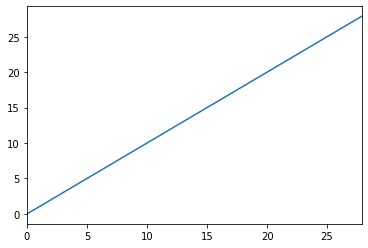

Consumption function at each aggregate market resources gridpoint (in general equilibrium):


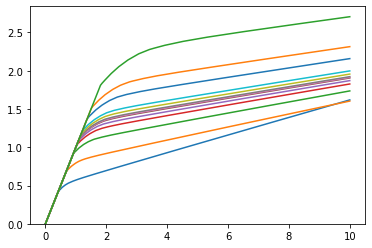

In [5]:
if solve_agg_shocks_market:
    # Solve the "macroeconomic" model by searching for a "fixed point dynamic rule"
    t_start = process_time()
    print(
        "Now solving for the equilibrium of a Cobb-Douglas economy.  This might take a few minutes..."
    )
    EconomyExample.solve()
    t_end = process_time()
    print(
        'Solving the "macroeconomic" aggregate shocks model took '
        + str(t_end - t_start)
        + " seconds."
    )

    print("Aggregate savings as a function of aggregate market resources:")
    plotFuncs(EconomyExample.AFunc, 0, 2 * EconomyExample.kSS)
    print(
        "Consumption function at each aggregate market resources gridpoint (in general equilibrium):"
    )
    AggShockExample.unpackcFunc()
    m_grid = np.linspace(0, 10, 200)
    AggShockExample.unpackcFunc()
    for M in AggShockExample.Mgrid.tolist():
        mMin = AggShockExample.solution[0].mNrmMin(M)
        c_at_this_M = AggShockExample.cFunc[0](m_grid + mMin, M * np.ones_like(m_grid))
        plt.plot(m_grid + mMin, c_at_this_M)
    plt.ylim(0.0, None)
    plt.show()

### Example Implementations of AggShockMarkovConsumerType

In [6]:
if solve_markov_micro or solve_markov_market or solve_krusell_smith:
    # Make a Markov aggregate shocks consumer type
    AggShockMrkvExample = AggShockMarkovConsumerType()
    AggShockMrkvExample.IncomeDstn[0] = 2 * [AggShockMrkvExample.IncomeDstn[0]]
    AggShockMrkvExample.cycles = 0

    # Make a Cobb-Douglas economy for the agents
    MrkvEconomyExample = CobbDouglasMarkovEconomy(agents=[AggShockMrkvExample])
    MrkvEconomyExample.DampingFac = 0.2  # Turn down damping
    MrkvEconomyExample.makeAggShkHist()  # Simulate a history of aggregate shocks
    AggShockMrkvExample.getEconomyData(
        MrkvEconomyExample
    )  # Have the consumers inherit relevant objects from the economy

In [7]:
if solve_markov_micro:
    # Solve the microeconomic model for the Markov aggregate shocks example type (and display results)
    t_start = process_time()
    AggShockMrkvExample.solve()
    t_end = process_time()
    print(
        "Solving an aggregate shocks Markov consumer took "
        + mystr(t_end - t_start)
        + " seconds."
    )

    print(
        "Consumption function at each aggregate market \
            resources-to-labor ratio gridpoint (for each macro state):"
    )
    m_grid = np.linspace(0, 10, 200)
    AggShockMrkvExample.unpackcFunc()
    for i in range(2):
        for M in AggShockMrkvExample.Mgrid.tolist():
            mMin = AggShockMrkvExample.solution[0].mNrmMin[i](M)
            c_at_this_M = AggShockMrkvExample.cFunc[0][i](
                m_grid + mMin, M * np.ones_like(m_grid)
            )
            plt.plot(m_grid + mMin, c_at_this_M)
        plt.ylim(0.0, None)
        plt.show()

Now solving a two-state Markov economy.  This should take a few minutes...
intercept=[-0.4763919075683026, -0.5605544369541379], slope=[1.1315727085579905, 1.1784066840697955], r-sq=[0.9980357482765062, 0.992696271776762]
intercept=[-0.39095559816014036, -0.4457821669469404], slope=[1.0767802376996618, 1.0975528936715868], r-sq=[0.9997778937148697, 0.9993871253581352]
intercept=[-0.33619865417943023, -0.38575550678402043], slope=[1.065065910802989, 1.0805465997572978], r-sq=[0.999891358395434, 0.9998295590476789]
intercept=[-0.3432267617513098, -0.394964908815329], slope=[1.0683284142653506, 1.0842599085384828], r-sq=[0.9998880408795819, 0.9998336351551399]
intercept=[-0.34405827074754763, -0.39550172544497686], slope=[1.0686668533613826, 1.0844827372272523], r-sq=[0.9998867796647407, 0.9998295883131055]
intercept=[-0.34414258628161926, -0.3955254835582317], slope=[1.0686979703844464, 1.0844934760168592], r-sq=[0.9998867084211823, 0.9998293196888337]
Solving the "macroeconomic" aggrega

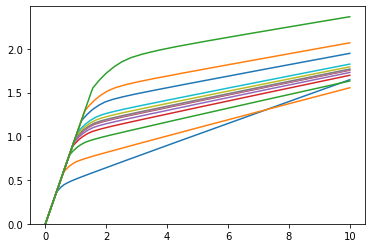

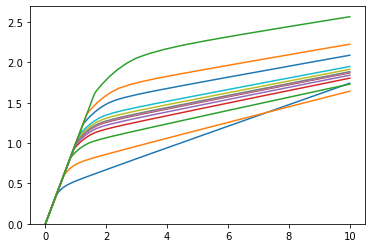

In [8]:
if solve_markov_market:
    # Solve the "macroeconomic" model by searching for a "fixed point dynamic rule"
    t_start = process_time()
    print("Now solving a two-state Markov economy.  This should take a few minutes...")
    MrkvEconomyExample.solve()
    t_end = process_time()
    print(
        'Solving the "macroeconomic" aggregate shocks model took '
        + str(t_end - t_start)
        + " seconds."
    )

    print(
        "Consumption function at each aggregate market \
            resources-to-labor ratio gridpoint (for each macro state):"
    )
    m_grid = np.linspace(0, 10, 200)
    AggShockMrkvExample.unpackcFunc()
    for i in range(2):
        for M in AggShockMrkvExample.Mgrid.tolist():
            mMin = AggShockMrkvExample.solution[0].mNrmMin[i](M)
            c_at_this_M = AggShockMrkvExample.cFunc[0][i](
                m_grid + mMin, M * np.ones_like(m_grid)
            )
            plt.plot(m_grid + mMin, c_at_this_M)
        plt.ylim(0.0, None)
        plt.show()

In [9]:
if solve_krusell_smith:
    # Make a Krusell-Smith agent type
    # NOTE: These agents aren't exactly like KS, as they don't have serially correlated unemployment
    KSexampleType = deepcopy(AggShockMrkvExample)
    KSexampleType.IncomeDstn[0] = [
        DiscreteDistribution(
            np.array([0.96, 0.04]),
            [ np.array([1.0, 1.0]), np.array([1.0 / 0.96, 0.0])]
        ),
        DiscreteDistribution(
            np.array([0.90, 0.10]),
            [np.array([1.0, 1.0]), np.array([1.0 / 0.90, 0.0])],
        )
    ]

    # Make a KS economy
    KSeconomy = deepcopy(MrkvEconomyExample)
    KSeconomy.agents = [KSexampleType]
    KSeconomy.AggShkDstn = [
        DiscreteDistribution(
            np.array([1.0]),
            [np.array([1.0]), np.array([1.05])],
        ),
        DiscreteDistribution(
            np.array([1.0]),
            [np.array([1.0]), np.array([0.95])],
        )
    ]
    KSeconomy.PermGroFacAgg = [1.0, 1.0]
    KSexampleType.getEconomyData(KSeconomy)
    KSeconomy.makeAggShkHist()

    # Solve the K-S model
    t_start = process_time()
    print(
        "Now solving a Krusell-Smith-style economy.  This should take about a minute..."
    )
    KSeconomy.solve()
    t_end = process_time()
    print("Solving the Krusell-Smith model took " + str(t_end - t_start) + " seconds.")

Now solving a Krusell-Smith-style economy.  This should take about a minute...
intercept=[-0.6802984623106902, -0.6431367270162477], slope=[1.209795459842345, 1.1961401168569106], r-sq=[0.9979223130501177, 0.9976587726885611]
intercept=[-0.32275443897362316, -0.3194451509948524], slope=[1.0473220816804483, 1.0494728168169827], r-sq=[0.9999337811632424, 0.9997455133811823]
intercept=[-0.3564300162992267, -0.3507492671084464], slope=[1.069897737358589, 1.0693490744529066], r-sq=[0.9999983030262461, 0.9999951958721364]
intercept=[-0.378627838628238, -0.37081574442530124], slope=[1.078591817537555, 1.0772217264163788], r-sq=[0.9999978207977982, 0.9999918615468698]
intercept=[-0.3792507255074706, -0.3713903991862787], slope=[1.0788253498029245, 1.0774542976829347], r-sq=[0.9999977807761196, 0.9999913958790368]
intercept=[-0.37925605613899416, -0.3714036447878481], slope=[1.0788258749145858, 1.0774600093517726], r-sq=[0.9999977804475141, 0.999991383709118]
Solving the Krusell-Smith model too

In [10]:
if solve_poly_state:
    StateCount = 15  # Number of Markov states
    GrowthAvg = 1.01  # Average permanent income growth factor
    GrowthWidth = 0.02  # PermGroFacAgg deviates from PermGroFacAgg in this range
    Persistence = 0.90  # Probability of staying in the same Markov state
    PermGroFacAgg = np.linspace(
        GrowthAvg - GrowthWidth, GrowthAvg + GrowthWidth, num=StateCount
    )

    # Make the Markov array with chosen states and persistence
    PolyMrkvArray = np.zeros((StateCount, StateCount))
    for i in range(StateCount):
        for j in range(StateCount):
            if i == j:
                PolyMrkvArray[i, j] = Persistence
            elif (i == (j - 1)) or (i == (j + 1)):
                PolyMrkvArray[i, j] = 0.5 * (1.0 - Persistence)
    PolyMrkvArray[0, 0] += 0.5 * (1.0 - Persistence)
    PolyMrkvArray[StateCount - 1, StateCount - 1] += 0.5 * (1.0 - Persistence)

    # Make a consumer type to inhabit the economy
    PolyStateExample = AggShockMarkovConsumerType()
    PolyStateExample.MrkvArray = PolyMrkvArray
    PolyStateExample.PermGroFacAgg = PermGroFacAgg
    PolyStateExample.IncomeDstn[0] = StateCount * [PolyStateExample.IncomeDstn[0]]
    PolyStateExample.cycles = 0

    # Make a Cobb-Douglas economy for the agents
    # Use verbose=False to remove printing of intercept
    PolyStateEconomy = CobbDouglasMarkovEconomy(agents=[PolyStateExample], verbose=False)
    PolyStateEconomy.MrkvArray = PolyMrkvArray
    PolyStateEconomy.PermGroFacAgg = PermGroFacAgg
    PolyStateEconomy.PermShkAggStd = StateCount * [0.006]
    PolyStateEconomy.TranShkAggStd = StateCount * [0.003]
    PolyStateEconomy.slope_prev = StateCount * [1.0]
    PolyStateEconomy.intercept_prev = StateCount * [0.0]
    PolyStateEconomy.update()
    PolyStateEconomy.makeAggShkDstn()
    PolyStateEconomy.makeAggShkHist()  # Simulate a history of aggregate shocks
    PolyStateExample.getEconomyData(
        PolyStateEconomy
    )  # Have the consumers inherit relevant objects from the economy

    # Solve the many state model
    t_start = process_time()
    print(
        "Now solving an economy with "
        + str(StateCount)
        + " Markov states.  This might take a while..."
    )
    PolyStateEconomy.solve()
    t_end = process_time()
    print(
        "Solving a model with "
        + str(StateCount)
        + " states took "
        + str(t_end - t_start)
        + " seconds."
    )